In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kalman.gaussian import GaussianState
from kalman.extended import ExtendedKalmanFilter
from kalman.unscented import UnscentedKalmanFilter
from kalman.filters import KalmanFilter
from kalman.vkf import VBKalmanFilter

In [3]:
# ----------------------------------------------------------
#   Configuration
# ----------------------------------------------------------
dt          = 0.1                         # time step
state_dim   = 4                           # [x, y, vx, vy]
obs_dim     = 2                           # [range, bearing]
num_steps   = 100

# ----------------------------------------------------------
#   Noise statistics
# ----------------------------------------------------------
process_noise     = torch.diag(torch.tensor([0.1, 0.1, 0.5, 0.5]))**2   # Q  (4×4)
measurement_noise = torch.diag(torch.tensor([0.02, 0.02]))**2           # R  (2×2)

# ----------------------------------------------------------
#   Non‑linear process model  f(x)
# ----------------------------------------------------------
def f_cv_turn(x: torch.Tensor) -> torch.Tensor:
    """
    Constant–speed planar motion with a small deterministic turn.
    x: (..., 4)  ->  (..., 4)
    """
    x_pos, y_pos, vx, vy = torch.unbind(x, dim=-1)

    speed = torch.sqrt(vx**2 + vy**2)                 # |v|
    angle = torch.atan2(vy, vx)
    new_angle = angle + 0.1 * dt                      # small turn

    vx_new = speed * torch.cos(new_angle)
    vy_new = speed * torch.sin(new_angle)

    x_new = x_pos + vx_new * dt
    y_new = y_pos + vy_new * dt

    return torch.stack((x_new, y_new, vx_new, vy_new), dim=-1)

# ----------------------------------------------------------
# Measurement model  h(x)
# ----------------------------------------------------------
def h_polar(x: torch.Tensor) -> torch.Tensor:
    """
    Cartesian -> polar [range, bearing].
    x: (..., 4) -> (..., 2)
    """
    x_pos, y_pos = x[..., 0], x[..., 1]
    r = torch.sqrt(x_pos**2 + y_pos**2)
    theta = torch.atan2(y_pos, x_pos)
    return torch.stack((r, theta), dim=-1)


In [4]:
# -----------------------------------------------------------------------
#     Build the Unscented Kalman Filter (all models + noise at once)
# -----------------------------------------------------------------------
process_matrix = torch.eye(state_dim)
process_matrix[0, 2] = dt
process_matrix[1, 3] = dt
measurement_matrix = torch.eye(obs_dim, state_dim)

kf = KalmanFilter(
    process_matrix=process_matrix,
    measurement_matrix=measurement_matrix,
    process_noise=process_noise,
    measurement_noise=measurement_noise
)

# -----------------------------------------------------------------------
#     Build the Unscented Kalman Filter (all models + noise at once)
# -----------------------------------------------------------------------
ukf = UnscentedKalmanFilter(
    state_dim = state_dim,
    obs_dim   = obs_dim,
    f         = f_cv_turn,
    h         = h_polar,
    Q         = process_noise,
    R         = measurement_noise,
    alpha=0.1, beta=2.0, kappa=0.0,
    eps=1e-7
)

# ----------------------------------------------------------
#     Build the Extended Kalman Filter (all models + noise at once)
# ----------------------------------------------------------
ekf = ExtendedKalmanFilter(
    state_dim   = state_dim,
    obs_dim     = obs_dim,
    f           = f_cv_turn,
    h           = h_polar,
    Q           = process_noise,
    R           = measurement_noise,
)

In [5]:
# ----------------------------------------------------------
#   Ground‑truth trajectory + noisy measurements
# ----------------------------------------------------------
def generate_measurements(state: torch.Tensor, num_steps: int, state_dim: int, obs_dim: int):
    """
    Generating a counterclockwise rotation of the point.
    """
    true_states   = torch.zeros(num_steps, state_dim)
    measurements  = torch.zeros(num_steps, obs_dim)
    
    for t in range(num_steps):
        # --- propagate truth with a *random* additional turn (not known to filter)
        speed       = torch.linalg.vector_norm(state[2:])
        angle       = torch.atan2(state[3], state[2])
        angle      += 0.1 * dt + 0.02 * torch.randn(())      # ~ small random perturbation
        state[2:]   = speed * torch.tensor([torch.cos(angle), torch.sin(angle)])
        state[0:2] += state[2:] * dt
        true_states[t] = state

        # --- sensor reading  z = h(x) + v
        r, theta = h_polar(state).tolist()
        measurements[t] = torch.tensor([
            r     + torch.randn(()) * measurement_noise[0, 0].sqrt(),
            theta + torch.randn(()) * measurement_noise[1, 1].sqrt()
        ])
    return measurements, true_states

In [6]:
state = torch.tensor([1.0, 0.0, 0.0, 1.0])
measurements, true_states = generate_measurements(state, num_steps, state_dim, obs_dim)

mean  = torch.tensor([1.0, 0.0, 0.0, 1.0])
cov   = torch.diag(torch.tensor([1.0, 1.0, 1.0, 1.0]))
# ----------------------------------------------------------
#   Run the Unscented Kalman Filter
# ----------------------------------------------------------
est_means_ukf = torch.zeros(num_steps, state_dim)
est_covs_ukf  = torch.zeros(num_steps, state_dim, state_dim)

state_est    = GaussianState(mean, cov)

for t in range(num_steps):
    state_est = ukf.predict_update(state_est, measurements[t])   # <‑‑ new call
    est_means_ukf[t] = state_est.mean
    est_covs_ukf[t]  = state_est.covariance


# ----------------------------------------------------------
#   Run the Extended Kalman Filter
# ----------------------------------------------------------
est_means_ekf = torch.zeros(num_steps, state_dim)
est_covs_ekf  = torch.zeros(num_steps, state_dim, state_dim)
state_est     = GaussianState(mean, cov)

for t in range(num_steps):
    state_est = ekf.predict_update(state_est, measurements[t])   # <‑‑ new call
    est_means_ekf[t] = state_est.mean
    est_covs_ekf[t]  = state_est.covariance


# ----------------------------------------------------------
#   Run the Kalman Filter
# ----------------------------------------------------------

# KF обработка
est_means_kf = torch.zeros(num_steps, state_dim)
est_covs_kf  = torch.zeros(num_steps, state_dim, state_dim)
state_est     = GaussianState(mean, cov)

for t in range(num_steps):
    state_est = kf.predict(state_est)
    state_est = kf.update(state_est, measurements[t])
    est_means_kf[t] = state_est.mean
    est_covs_kf[t] = state_est.covariance

KF error = 3.7967023849487305
UKF error = 0.2775914967060089
EKF error = 0.11807283759117126


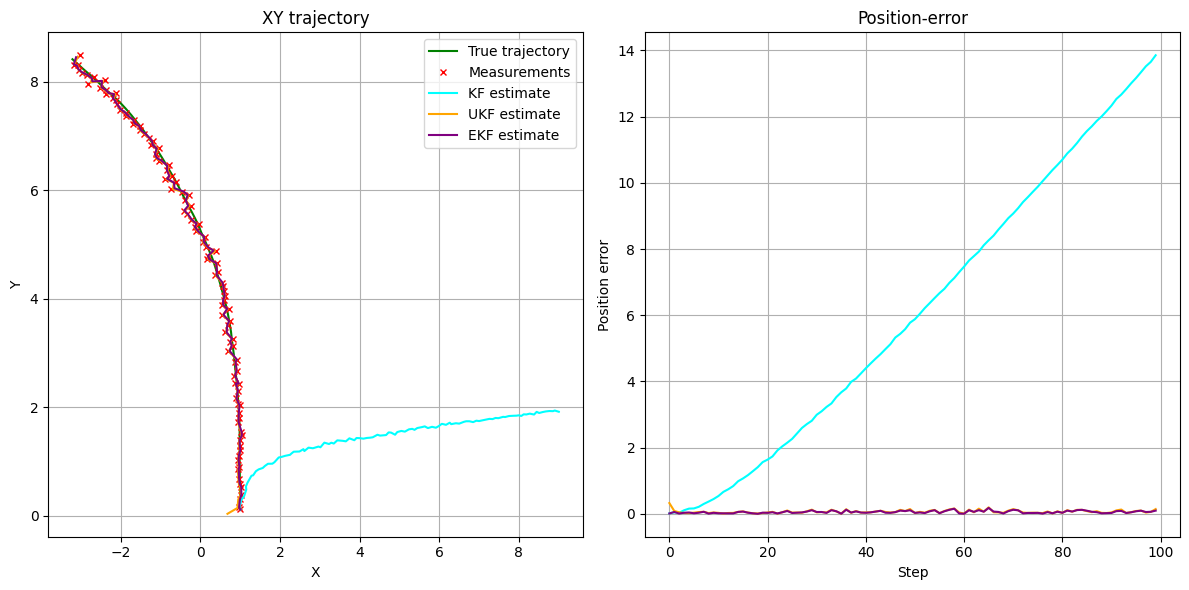

In [7]:
# -----------------------------------------------------------------------
#   Visualisation
# -----------------------------------------------------------------------
kf_errors_kf = torch.sqrt(torch.mean((est_means_kf - true_states)**2))
print(f"KF error = {kf_errors_kf}")

kf_errors_ukf = torch.sqrt(torch.mean((est_means_ukf - true_states)**2))
print(f"UKF error = {kf_errors_ukf}")
kf_errors_ekf = torch.sqrt(torch.mean((est_means_ekf - true_states)**2))
print(f"EKF error = {kf_errors_ekf}")

plt.figure(figsize=(12, 6))

# trajectory in XY
plt.subplot(1, 2, 1)
plt.plot(true_states[:, 0], true_states[:, 1], 'g-', label='True trajectory')
plt.plot(measurements[:, 0] * torch.cos(measurements[:, 1]),
        measurements[:, 0] * torch.sin(measurements[:, 1]),
         'rx', ms=4, label='Measurements')
plt.plot(est_means_kf[:, 0], est_means_kf[:, 1], color='cyan', linestyle='-', label='KF estimate')
plt.plot(est_means_ukf[:, 0], est_means_ukf[:, 1], color='orange', linestyle='-', label='UKF estimate')
plt.plot(est_means_ekf[:, 0], est_means_ekf[:, 1], color='purple', linestyle='-', label='EKF estimate')
plt.xlabel('X'); plt.ylabel('Y'); plt.title('XY trajectory')
plt.legend(); plt.grid(True)

# position‑error curve
position_err_kf = torch.sqrt(
    (est_means_kf[:, 0] - true_states[:, 0]) ** 2 +
    (est_means_kf[:, 1] - true_states[:, 1]) ** 2
)
position_err_ukf = torch.sqrt(
    (est_means_ukf[:, 0] - true_states[:, 0]) ** 2 +
    (est_means_ukf[:, 1] - true_states[:, 1]) ** 2
)
position_err_ekf = torch.sqrt(
    (est_means_ekf[:, 0] - true_states[:, 0]) ** 2 +
    (est_means_ekf[:, 1] - true_states[:, 1]) ** 2
)
plt.subplot(1, 2, 2)
plt.plot(position_err_kf, color='cyan', linestyle='-')
plt.plot(position_err_ukf, color='orange', linestyle='-')
plt.plot(position_err_ekf, color='purple', linestyle='-',)
plt.xlabel('Step'); plt.ylabel('Position error'); plt.title('Position‑error')
plt.grid(True)

plt.tight_layout(); plt.show()


## Variational Kalman filter for time-varying noise covariances

In [8]:
def h(x: torch.Tensor) -> torch.Tensor:
    return x[..., :2]

def generate_measurements_linear_sinusoidal_noise(
    initial_state: torch.Tensor, 
    num_steps: int, 
    state_dim: int, 
    obs_dim: int,
    dt: float,
    base_noise: torch.Tensor,
    noise_variation_amplitude: float = 0.5,
    noise_variation_period: float = 150.0
):
    # Linear process matrix (constant velocity model)
    F = torch.tensor([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32)
    
    true_states = torch.zeros(num_steps, state_dim)
    measurements = torch.zeros(num_steps, obs_dim)
    state = initial_state.clone()
    
    for t in range(num_steps):
        # --- Linear state propagation
        state = F @ state
        true_states[t] = state
        
        # --- Time-varying noise (sinusoidal variation)
        noise_scale = torch.relu(torch.sin(torch.tensor(2 * torch.pi * (t + 75) / noise_variation_period))) * 3. + 0.05
        
        current_noise = base_noise * noise_scale
        
        # --- Sensor reading z = h(x) + v with time-varying noise
        x, y = h(state).tolist()
        measurements[t] = torch.tensor([
            x + torch.randn(()) * current_noise[0, 0].sqrt(),
            y + torch.randn(()) * current_noise[1, 1].sqrt()
        ])
    
    return measurements, true_states

In [9]:
# Parameters
dt = 0.1
num_steps = 500
state_dim = 4
obs_dim = 2
initial_state = torch.tensor([0.0, 0.0, 1.0, 0.01])  # [x, y, vx, vy]
base_noise = torch.diag(torch.tensor([0.1, 0.01]))  # x, y variances

# Generate measurements
measurements, true_states = generate_measurements_linear_sinusoidal_noise(
    initial_state=initial_state,
    num_steps=num_steps,
    state_dim=state_dim,
    obs_dim=obs_dim,
    dt=dt,
    base_noise=base_noise
)

In [14]:
# -----------------------------------------------------------------------
#     Build the Kalman Filter (all models + noise at once)
# -----------------------------------------------------------------------
process_matrix = torch.eye(state_dim)
process_matrix[0, 2] = dt
process_matrix[1, 3] = dt
measurement_matrix = torch.eye(obs_dim, state_dim)

kf = KalmanFilter(
    process_matrix=process_matrix,
    measurement_matrix=measurement_matrix,
    process_noise=process_noise,
    measurement_noise=base_noise
)

# -----------------------------------------------------------------------
#     Build the Variational Kalman Filter (all models + noise at once)
# -----------------------------------------------------------------------
process_matrix = torch.eye(state_dim)
process_matrix[0, 2] = dt
process_matrix[1, 3] = dt
measurement_matrix = torch.eye(obs_dim, state_dim)

vkf = VBKalmanFilter(
    process_matrix=process_matrix,
    measurement_matrix=measurement_matrix,
    process_noise=process_noise,
    initial_measurement_cov=base_noise,
    rho=0.95
)

In [15]:

# ----------------------------------------------------------
#   Run the Kalman Filter
# ----------------------------------------------------------

# KF обработка
est_means_kf = torch.zeros(num_steps, state_dim)
est_covs_kf  = torch.zeros(num_steps, state_dim, state_dim)
state_est     = GaussianState(mean, cov)

for t in range(num_steps):
    state_est = kf.predict(state_est)
    state_est = kf.update(state_est, measurements[t])
    est_means_kf[t] = state_est.mean
    est_covs_kf[t] = state_est.covariance


# ----------------------------------------------------------
#   Run the Variational Kalman Filter
# ----------------------------------------------------------

# KF обработка
est_means_vkf = torch.zeros(num_steps, state_dim)
measure_covs_vkf = torch.zeros(num_steps, obs_dim)
est_covs_vkf  = torch.zeros(num_steps, state_dim, state_dim)
state_est     = GaussianState(mean, cov)

for t in range(num_steps):
    state_est = vkf.predict(state_est)
    state_est = vkf.update(state_est, measurements[t])
    est_means_vkf[t] = state_est.mean
    est_covs_vkf[t] = state_est.covariance
    measure_covs_vkf[t] = vkf.get_measurement_covariance().diag()

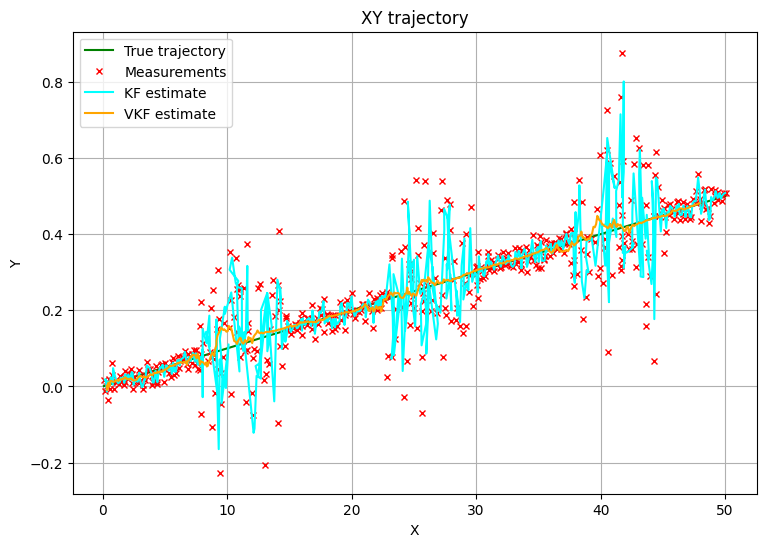

In [22]:
# -----------------------------------------------------------------------
#   Visualisation
# -----------------------------------------------------------------------
plt.figure(figsize=(30, 6))

# ------------------------------------------
# 1. Trajectory in XY
# ------------------------------------------
plt.subplot(1, 3, 1)
plt.plot(true_states[:, 0], true_states[:, 1], 'g-', label='True trajectory')
plt.plot(measurements[:, 0], measurements[:, 1], 'rx', ms=4, label='Measurements')
plt.plot(est_means_kf[:, 0], est_means_kf[:, 1], color='cyan', linestyle='-', label='KF estimate')
plt.plot(est_means_vkf[:, 0], est_means_vkf[:, 1], color='orange', linestyle='-', label='VKF estimate')
plt.xlabel('X'); plt.ylabel('Y'); plt.title('XY trajectory')
plt.legend(); plt.grid(True)

## Detail visualization on Unscented and Extended Kalman Filter

UKF error = 0.2775914967060089
EKF error = 0.11807283759117126


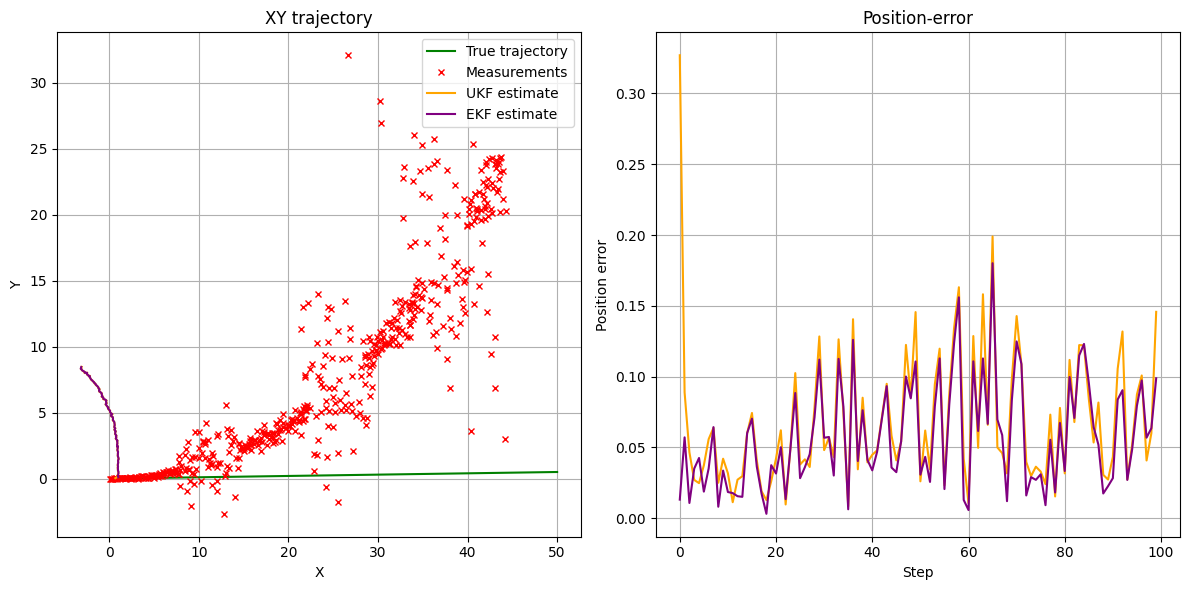

In [23]:
# -----------------------------------------------------------------------
#   Visualisation
# -----------------------------------------------------------------------
print(f"UKF error = {kf_errors_ukf}")
print(f"EKF error = {kf_errors_ekf}")

plt.figure(figsize=(12, 6))
# trajectory in XY
plt.subplot(1, 2, 1)
plt.plot(true_states[:, 0], true_states[:, 1], 'g-', label='True trajectory')
plt.plot(measurements[:, 0] * torch.cos(measurements[:, 1]),
         measurements[:, 0] * torch.sin(measurements[:, 1]),
         'rx', ms=4, label='Measurements')
plt.plot(est_means_ukf[:, 0], est_means_ukf[:, 1], color='orange', linestyle='-', label='UKF estimate')
plt.plot(est_means_ekf[:, 0], est_means_ekf[:, 1], color='purple', linestyle='-', label='EKF estimate')
plt.xlabel('X'); plt.ylabel('Y'); plt.title('XY trajectory')
plt.legend(); plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(position_err_ukf, color='orange', linestyle='-')
plt.plot(position_err_ekf, color='purple', linestyle='-',)
plt.xlabel('Step'); plt.ylabel('Position error'); plt.title('Position‑error')
plt.grid(True)

plt.tight_layout(); plt.show()
